## Demo_UMAP
This is a demo for visualizing the UMAP of a Neuron Network

To run this demo from scratch, you need first generate a BadNet attack result by using the following cell

In [ ]:
! python ../../attack/badnet.py --save_folder_name badnet_demo

or run the following command in your terminal

```python attack/badnet.py --save_folder_name badnet_demo```

#### Difference between UMAP and T-SNE
* Both of them can be used for dimension reduction, i.e., reducing the dimension of given features. But, UMAP is much faster than T-SNE which allows us to use more samples for a more comprehensive view.

### Step 1: Import modules and set arguments

In [1]:
import sys, os
import yaml
import torch
import numpy as np
import torchvision.transforms as transforms

sys.path.append("../")
sys.path.append("../../")
sys.path.append(os.getcwd())
from visual_utils import *
from utils.aggregate_block.dataset_and_transform_generate import (
    get_transform,
    get_dataset_denormalization,
)
from utils.aggregate_block.fix_random import fix_random
from utils.aggregate_block.model_trainer_generate import generate_cls_model
from utils.save_load_attack import load_attack_result
from utils.defense_utils.dbd.model.utils import (
    get_network_dbd,
    load_state,
    get_criterion,
    get_optimizer,
    get_scheduler,
)
from utils.defense_utils.dbd.model.model import SelfModel, LinearModel


In [2]:

### Basic setting: args
args = get_args(True)

########## For Demo Only ##########
args.yaml_path = "../../"+args.yaml_path
args.result_file_attack = "badnet_demo"
######## End For Demo Only ##########

with open(args.yaml_path, "r") as stream:
    config = yaml.safe_load(stream)
config.update({k: v for k, v in args.__dict__.items() if v is not None})
args.__dict__ = config
args = preprocess_args(args)
fix_random(int(args.random_seed))

save_path_attack = "../..//record/" + args.result_file_attack


### Step 2: Load data

In [3]:
# Load result
result_attack = load_attack_result(save_path_attack + "/attack_result.pt")
selected_classes = np.arange(args.num_classes)

# Select classes to visualize
if args.num_classes>args.c_sub:
    selected_classes = np.delete(selected_classes, args.target_class)
    selected_classes = np.random.choice(selected_classes, args.c_sub-1, replace=False)
    selected_classes = np.append(selected_classes, args.target_class)

# keep the same transforms for train and test dataset for better visualization
result_attack["clean_train"].wrap_img_transform = result_attack["clean_test"].wrap_img_transform 
result_attack["bd_train"].wrap_img_transform = result_attack["bd_test"].wrap_img_transform 

args.visual_dataset = "bd_train"
args.n_sub = 50000
# Create dataset
if args.visual_dataset == 'mixed':
    bd_test_with_trans = result_attack["bd_test"]
    visual_dataset = generate_mix_dataset(bd_test_with_trans, args.target_class, args.pratio, selected_classes, max_num_samples=args.n_sub)
elif args.visual_dataset == 'clean_train':
    clean_train_with_trans = result_attack["clean_train"]
    visual_dataset = generate_clean_dataset(clean_train_with_trans, selected_classes, max_num_samples=args.n_sub)
elif args.visual_dataset == 'clean_test':
    clean_test_with_trans = result_attack["clean_test"]
    visual_dataset = generate_clean_dataset(clean_test_with_trans, selected_classes, max_num_samples=args.n_sub)
elif args.visual_dataset == 'bd_train':  
    bd_train_with_trans = result_attack["bd_train"]
    visual_dataset = generate_bd_dataset(bd_train_with_trans, args.target_class, selected_classes, max_num_samples=args.n_sub)
else:
    assert False, "Illegal vis_class"

print(f'Create visualization dataset with \n \t Dataset: {args.visual_dataset} \n \t Number of samples: {len(visual_dataset)}  \n \t Selected classes: {selected_classes}')

# Create data loader
data_loader = torch.utils.data.DataLoader(
    visual_dataset, batch_size=args.batch_size, num_workers=args.num_workers, shuffle=False
)

# Create denormalization function
for trans_t in data_loader.dataset.wrap_img_transform.transforms:
    if isinstance(trans_t, transforms.Normalize):
        denormalizer = get_dataset_denormalization(trans_t)



Files already downloaded and verified
Files already downloaded and verified
loading...
max_num_samples is given, use sample number limit now.
subset bd dataset with length:  50000
Create visualization dataset with 
 	 Dataset: bd_train 
 	 Number of samples: 50000  
 	 Selected classes: [0 1 2 3 4 5 6 7 8 9]


### Step 3: Load Model

In [4]:
# Load model
model_visual = generate_cls_model(args.model, args.num_classes)
model_visual.load_state_dict(result_attack["model"])
model_visual.to(args.device)
# !!! Important to set eval mode !!!
model_visual.eval()
print(f"Load model {args.model} from {args.result_file_attack}")

Load model preactresnet18 from badnet_demo


### Step 4: Plot UMAP

Plotting UMAP
Choose layer layer4.1.conv2 from model preactresnet18


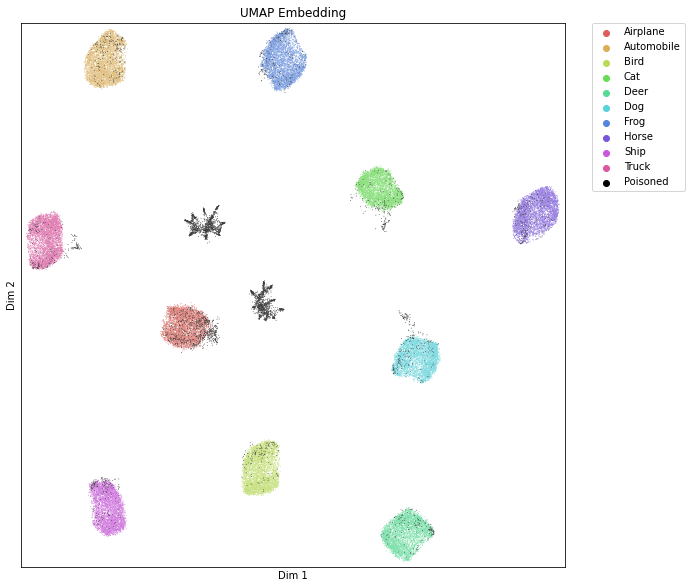

In [5]:
############## UMAP ##################
print("Plotting UMAP")

# Choose layer for feature extraction
module_dict = dict(model_visual.named_modules())
target_layer = module_dict[args.target_layer_name]
print(f'Choose layer {args.target_layer_name} from model {args.model}')

# Get features
features, labels, poi_indicator = get_features(args, model_visual, target_layer, data_loader)

# General plotting parameters
custom_palette = sns.color_palette("hls", np.unique(labels).shape[0])
classes = args.class_names

# Setting parameters for Poisoned Samples
# use poi_indicator==1 to avoid some datatype issue for indexing
if np.sum(poi_indicator)>0:
    # Label: args.num_classes
    labels[poi_indicator==1]=args.num_classes
    # Class Name: poisoned
    classes += ["poisoned"]
    # Color: Black
    custom_palette += [(0.0, 0.0, 0.0)] 

sort_idx = np.argsort(labels)
features = features[sort_idx]
labels = labels[sort_idx]
label_class = [classes[i].capitalize() for i in labels]

# Plot T-SNE
fig = umap_fig(
    features,
    label_class,
    title="UMAP Embedding",
    xlabel="Dim 1",
    ylabel="Dim 2",
    custom_palette=custom_palette,
    size=(10, 10),
    mark_size = 0.6,
    alpha = 1
)